https://doordash.engineering/2020/09/18/causal-modeling-to-get-more-value-from-flat-experiment-results/comment-page-1/?unapproved=16&moderation-hash=7fa9a26e6386c27d25dbca6d1c777441#comments



One Model Approach, TMA: XGBoost </br>

Meta-Learns: X-Regressors </br>

Class transformation Apporach: TOT "Y* = Y(W-P)/P(1-P" </br>

𝑈𝑝𝑙𝑖𝑓𝑡 𝐿𝐺𝑊𝑈𝑀 = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C) </br>
https://www.kaggle.com/viswanathgang/criteo-uplift-modelling-viswanath/edit?rvi=1


PyLift package </br>


Report numbers at bigger samples </br>


Extreme predicted Negative uplift has postivie observed uplift </br>



In [1]:
import pandas as pd


from pylift import TransformedOutcome
import numpy as np

from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import math



import matplotlib.pyplot as plt
import subprocess
import sys

from pylift import TransformedOutcome
from pylift.eval import UpliftEval
import random
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster import contingency_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
df = pd.read_csv('/Users/viswanath.g/Downloads/criteo-uplift-v2.1.csv')

In [4]:
print(df.agg({'treatment':['mean'], 'visit':['mean'], 'conversion':['mean']}))
print(df.groupby(['treatment']).agg({'conversion':['mean'], 'visit':['mean'], }))
print(df.groupby(['treatment', 'exposure']).agg({'conversion':['mean', 'count'], 'visit':['mean', 'count'], }))

      treatment     visit  conversion
mean       0.85  0.046992    0.002917
          conversion     visit
                mean      mean
treatment                     
0           0.001938  0.038201
1           0.003089  0.048543
                   conversion               visit          
                         mean     count      mean     count
treatment exposure                                         
0         0          0.001938   2096937  0.038201   2096937
1         0          0.001194  11454443  0.034861  11454443
          1          0.053784    428212  0.414538    428212


##### Two Model Approach

<ipython-input-13-23c797a147e1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] )


q2_aqini:  0.08511245584180498 q2_qini:  0.10138307639048243 q2_cgains:  0.0824683286140237


<AxesSubplot:title={'center':'Cumulative gain chart'}, xlabel='Fraction of data', ylabel='Uplift gain'>

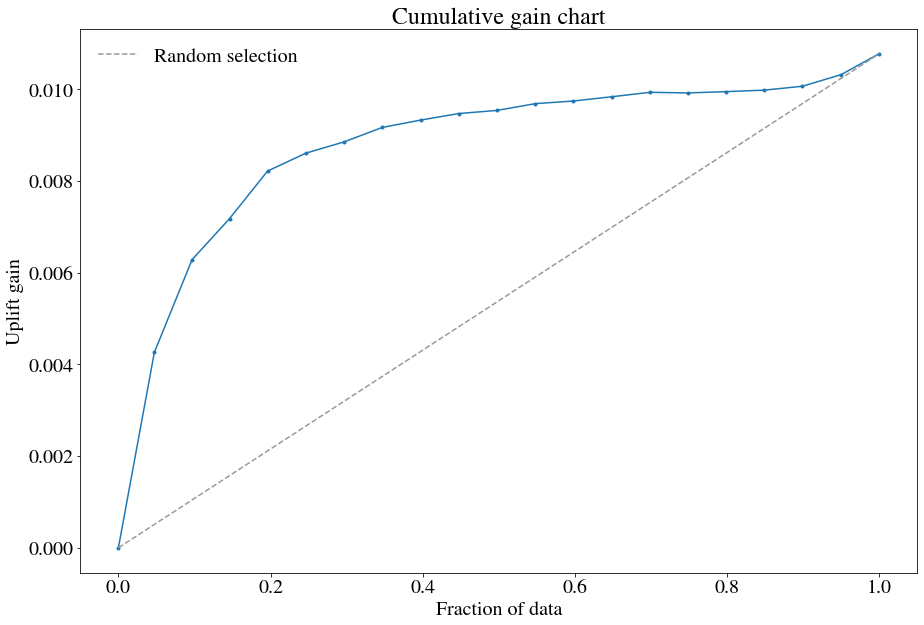

In [13]:
# Incremental Effect of Intervention on Visit
df_sample_train = df.sample(frac =.01) 
df_sample_train.drop(['conversion', 'exposure'], inplace=True, axis=1)

test_data    = df_sample_train[df_sample_train.treatment == True ]
control_data = df_sample_train[df_sample_train.treatment == False] 

P_T = GradientBoostingClassifier().fit(test_data.drop(['visit', 'treatment'], axis=1),    test_data   ['visit'] )
P_C = GradientBoostingClassifier().fit(control_data.drop(['visit', 'treatment'], axis=1), control_data['visit'] )

test_data_val_pred    = P_T.predict_proba( control_data.drop(['visit', 'treatment'], axis=1) )
control_data_val_pred = P_C.predict_proba( control_data.drop(['visit', 'treatment'], axis=1) )

control_data['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(df_sample_val.treatment, df_sample_val.visit, df_sample_val.uplift)
print('q2_aqini: ', upev.q2_aqini, 'q2_qini: ', upev.q2_qini, 'q2_cgains: ', upev.q2_cgains)
upev.plot(plot_type='cgains')

In [ ]:
print('q2_aqini: ', upev.q2_aqini, 'q2_qini: ', upev.q2_qini, 'q2_cgains: ', upev.q2_cgains)

(593788, 14) (105192, 14)
(698980, 14)


<AxesSubplot:title={'center':'Adjusted Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

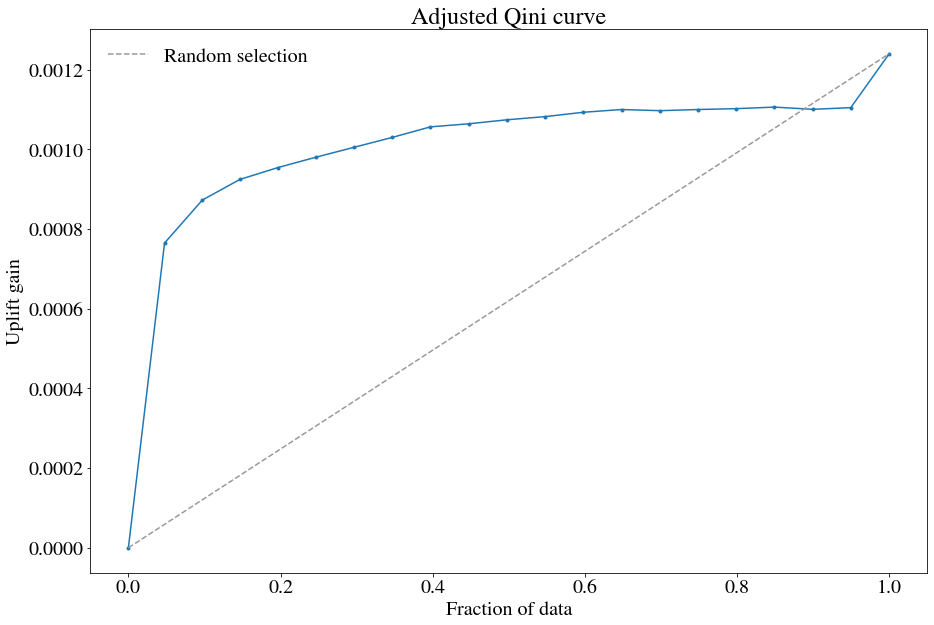

In [6]:
# generating one row  
df_sample_train = df.sample(frac =.05) 
df_sample_train.drop(['visit', 'exposure'], inplace=True, axis=1)
test_data    = df_sample_train[df_sample_train.treatment == True ]
control_data = df_sample_train[df_sample_train.treatment == False] 
print(test_data.shape, control_data.shape)

P_T = GradientBoostingClassifier().fit(test_data.drop(  ['conversion', 'treatment'], axis=1),  test_data   ['conversion'] )
P_C = GradientBoostingClassifier().fit(control_data.drop(['conversion', 'treatment'], axis=1), control_data['conversion'] )

# generating one row  
df_sample_val = df.sample(frac =.05) 
df_sample_val.drop(['visit', 'exposure'], inplace=True, axis=1)
print(df_sample_val.shape)

test_data_val_pred    = P_T.predict_proba( df_sample_val.drop(['conversion', 'treatment'], axis=1) )
control_data_val_pred = P_C.predict_proba( df_sample_val.drop(['conversion', 'treatment'], axis=1) )

df_sample_val['uplift'] = ( test_data_val_pred[:,1] - control_data_val_pred[:,1] ) 
upev = UpliftEval(df_sample_val.treatment, df_sample_val.conversion, df_sample_val.uplift)
upev.plot(plot_type='aqini')

In [7]:
aqini  = []
qini   = []
cgains = []

for i in range(10):

    df_sample_train = df.sample(frac =.05) 
    df_sample_train.drop( ['conversion', 'exposure'], inplace=True, axis=1 )
    test_data    = df_sample_train[df_sample_train.treatment == True ]
    control_data = df_sample_train[df_sample_train.treatment == False] 
    
    P_T = GradientBoostingClassifier().fit(test_data.drop(['visit', 'treatment'], axis=1),    test_data   ['visit'] )
    P_C = GradientBoostingClassifier().fit(control_data.drop(['visit', 'treatment'], axis=1), control_data['visit'] )
    
    
    df_sample_val = df.sample(frac =.05) 
    df_sample_val.drop(['conversion', 'exposure'], inplace=True, axis=1)
    
    test_data_val_pred    = P_T.predict_proba( df_sample_val.drop(['visit', 'treatment'], axis=1) )
    control_data_val_pred = P_C.predict_proba( df_sample_val.drop(['visit', 'treatment'], axis=1) )

    df_sample_val['uplift'] = ( test_data_val_pred[:,0] - control_data_val_pred[:,0] ) 
    
    upev = UpliftEval(df_sample_val.treatment, df_sample_val.visit, df_sample_val.uplift)
    
    aqini.append ( upev.q2_aqini )
    qini.append  ( upev.q2_qini  )
    cgains.append( upev.q2_cgains)

print(f'aqini  mean: {round(np.average(aqini),2)},  aqini  std: {round(np.std(aqini),2)}' )
print(f'qini   mean: {round(np.average(qini),2) },  qini   std: {round(np.std(qini),2)}'  )
print(f'cgains mean: {round(np.average(cgains),2)}, cgains std: {round(np.std(cgains),2)}')

aqini  mean: -0.1,  aqini  std: 0.01
qini   mean: -0.1,  qini   std: 0.01
cgains mean: -0.1, cgains std: 0.01


In [8]:
aqini  = []
qini   = []
cgains = []

for i in range(5):

    df_sample_train = df.sample(frac =.05) 
    df_sample_train.drop( ['visit', 'exposure'], inplace=True, axis=1 )
    test_data    = df_sample_train[df_sample_train.treatment == True ]
    control_data = df_sample_train[df_sample_train.treatment == False] 
    
    P_T = GradientBoostingClassifier().fit(test_data.drop(   ['conversion', 'treatment'], axis=1), test_data   ['conversion'] )
    P_C = GradientBoostingClassifier().fit(control_data.drop(['conversion', 'treatment'], axis=1), control_data['conversion'] )
    
    
    df_sample_val = df.sample(frac =.05) 
    df_sample_val.drop(['visit', 'exposure'], inplace=True, axis=1)
    
    
    test_data_val_pred    = P_T.predict_proba( df_sample_val.drop(['conversion', 'treatment'], axis=1) )
    control_data_val_pred = P_C.predict_proba( df_sample_val.drop(['conversion', 'treatment'], axis=1) )

    df_sample_val['uplift'] = ( test_data_val_pred[:,0] - control_data_val_pred[:,0] ) 
    
    upev = UpliftEval(df_sample_val.treatment, df_sample_val.conversion, df_sample_val.uplift)
    
    aqini.append ( upev.q2_aqini )
    qini.append  ( upev.q2_qini  )
    cgains.append( upev.q2_cgains)

print(f'aqini  mean: {round(np.average(aqini),2)},  aqini  std: {round(np.std(aqini),2)}' )
print(f'qini   mean: {round(np.average(qini),2) },  qini   std: {round(np.std(qini),2)}'  )
print(f'cgains mean: {round(np.average(cgains),2)}, cgains std: {round(np.std(cgains),2)}')

aqini  mean: -0.14,  aqini  std: 0.01
qini   mean: -0.14,  qini   std: 0.01
cgains mean: -0.14, cgains std: 0.01
